<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/46_Ultra_lite_%D0%9F%D0%BE%D0%B4%D0%B1%D0%BE%D1%80_%D0%B0%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

1. Перепишите создание свёрточной сети с помощью ГА полностью самостоятельно.

2. Можно взять готовыми лишь некоторые сложные функции.

3. Можно сделать другой формат свёрточной сети, не такой, как в ноутбуке.

4. Можно подсматривать в базовый ноутбук, но не копировать код напрямую.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка библиотек + код для просмотра инфо по выделенным ресурсам

In [ ]:
!ln -sf /opt/bin/invidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn't guaranteed
# Далее код cработает если переключить Colab на GPU !!!
gpu = GPUs[0] 
process = psutil.Process(os.getpid())
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)


Gen RAM Free: 10.9 GB  | Proc size: 3.4 GB
GPU RAM Free: 14537MB | Used: 1743MB | Util  11% | Total 16280MB
GPU Model:  Tesla P100-PCIE-16GB


In [ ]:
import pandas as pd
import numpy as np
import random as random
import time
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras import utils # для to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Reshape, Input, Conv1D, Dense, Flatten, MaxPool1D, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.losses import MAE
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from google.colab import files # загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from PIL import Image

# Статический вывод графики, отображаются в той ячейке, в которой используется plt.show()
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка данных

In [ ]:
# Считываем данные с помощью pandas
base_data = pd.read_csv("/content/drive/MyDrive/Базы/traff.csv", header=None)
base_data

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


In [ ]:
data = base_data.iloc[:,1]
data.head()

0    22,226.00
1    29,593.00
2    31,726.00
3    32,684.00
4    31,820.00
Name: 1, dtype: object

In [ ]:
# Выводим параметры одного файла
d = data
print(len(d))         # к-во записей
print(len(d.iloc[0])) # Длина строки
print(d.iloc[0])      # Пример строки

1095
9
22,226.00


In [ ]:
# Превращаем в numpy массив
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(",",""))

In [ ]:
# Загружаем данные
# Формируем параметры загрузки
xLen = 60    # Анализируем по прошедшим точкам
valLen = 300 # Используем 300 записей для проверки

trainLen = data.shape[0]-valLen # 1095 - 300 = 795

# Делим данные на тренировочную и тестовую выборки
Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))


# Масштабируем данные отдельно X и Y, чтобы их было легче скормить сетке
Scaler = MinMaxScaler() # Выбор нормализации
Scaler.fit(Train)       # Обучили на train
Train = Scaler.transform(Train) 
Test = Scaler.transform(Test)

# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(Train, Train,                  # наши выборки
                                   length=xLen, sampling_rate=1,  # для каждой точки 
                                   batch_size=20)

# Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
data.shape[0]

1095

# Функции для отображения результатов

In [ ]:
from ssl import CHANNEL_BINDING_TYPES
# Функция расчитывает результаты прогнозирования сети
# В аргументы принимает текущую сеть (currModel) и проверочную выборку
# Выдает результаты предсказания predVal
# И правильные ответы в исходной размерности
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходный масштаб данных
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return(predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку отчета
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(
      predVal[start:start+step, channel],
      label="Прогноз"
  )
  plt.plot(
      yValUnscaled[start:start+step, channel],
      label="Базовый ряд"
  )
  plt.xlabel("Время")
  plt.ylabel("Значение close")
  plt.legend()
  plt.show()

# Функция расчета корреляции двух одномерных векторов
def correlate(a, b):
  # Расчитываем основные показатели
  ma = a.mean() # Cреднее значение первого вектора
  mb = b.mean() # Cреднее значение второго вектора
  mab = (a*b).mean() # Cреднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение певого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора

  # Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция отрисовки корреляции прогноза сигнала и правильного сигнала
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для расчета корреляции
# showGraf - показываем график или нет
# returnData - возвращаем массивы автокорреляции или нет
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # создаем пустой лист,в нем будут корреляции при смещени на i шагов обратно
    yLen = yValUnscaled.shape[0] # запоминаем размер проверочной выборки

    # Постепенно увеличиваем шаг, на сколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещенный на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] #создаем пустой лист в нем будут корреляции при смещении на i шагов обратно

    # Постепенно увеличиваем шаг, на сколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещенный на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yCalUnscaled[:yLen-i, ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i, ch], yValUnscaled[i:, ch]))

    # Отображаем график корреляций для данного шага
    if showGraf: # если нужно показать график
      plt.plot(corr, label="предсказание на " + str(ch+1) + "шаг")
      plt.plot(own_corr, label="Эталон")

  if showGraf: # если нужно показать график
    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.legend()
    plt.show()

  if returnData: # если нужно показать массивы
    return corr, own_corr

# Генерируем проверочную выборку

In [ ]:
# Создадим генератор проверочной выборки
DataGen = TimeseriesGenerator(Test, Test,
                              length=xLen,
                              sampling_rate=1,
                              batch_size=len(Test))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

# Подбор линейной архитектуры


1.   Входной слой 

*   0 - делаем ли BN?
*   1 - размер первого Conv1D
*   2 - ядро первого Conv1D
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0?
*   5 - размер MaxPooling0

2.   Первый скрытый слой
*   6 - делаем ли второй Conv1D?
*   7 - размер второго Conv1D
*   8 - ядро второго Conv1D
*   9 - делаем ли MaxPooling1
*   10 - размер делаем ли MaxPooling1?
*   11 - функция активации

3.   Второй скрытый слой
*   12 - делаем ли третий Conv1D?
*   13 - размер третьего Conv1D
*   14 - ядро третьего Conv1D
*   15 - делаем ли MaxPooling2?
*   16 - размер MaxPooling2?
*   17 - функция активации
----------------------------------------------
*   18 - функция активации предпоследнего слоя
*   19 - функция активации выходного слоя
----------------------------------------------

4.   Третий скрытый слой
*   20 - делаем ли BN?
*   21 -размер Dense слоя

In [ ]:
# Создаем сеть (net - список параметров)
def createConvNet(net):  

  model = Sequential()             # Создаем моель Sequential

  makeFirstNormalization = net[0] # делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]     # размер первого сверточного слоя
  firstConvKernel = net[2]        # размер ядра первого сверточного слоя
  activation0 = net[3]            # функция активации входного слоя
  makeMaxPooling0 = net[4]        # делаем ли макспулинг для нулевого слоя
  maxpoolingSize0 = net[5]        # размер макспулинг

  makeSecondConv = net[6]         # делаем ли второй сверточный слой
  secondConvSize = 2 ** net[7]    # размер второго сверточного слоя
  secondConvKernel = net[8]       # ядро второго сверточного слоя
  makeMaxPooling1 = net[9]        # делаем ли макспулинг
  MaxPoolingSize1 = net[10]       # размер макспулинга
  activation1 = net[11]           # функция активации

  makeThirdConv = net[12]         # делаем ли третий сверточный слой
  thirdConvSize = 2 ** net[13]    # размер третьего сверточного слоя
  thirdConvKernel = net[14]       # размер ядра третьего сверточного слоя
  makeMaxPooling2 = net[15]       # делаем ли макспуллинг
  MaxPoolingSize2 = net[16]       # размер сверточного слоя макспуллинга
  activation2 = net[17]           # функция активации

  activation3 = net[18]           # функция активации на третьес слое
  activation4 = net[19]           # функция активации на четвертом слое

  makeSecondNormalization = net[20] # делаем ли финальную нормализацию 
  denseSize = 2 ** net[21]          # размер полносвязного слоя

  activation_list = ["linear", "relu", "tanh", "softmax", "sigmoid"]

  if (makeFirstNormalization): # Если делаем нормализацию в начале

    # Добавляем слой BN
    model.add(BatchNormalization(input_shape=(xLen,1)))

    #Добавляем Conv1D слой с firstConvSize нейронами и firstConvKernel размером ядра
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding="same"))
  else:

    # Добавляем Conv1D слой с firstConvSize нейронами и firstConvKernel размером ядра
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding="same"))
  
  if makeMaxPooling0: # если делаем макспулинг
    model.add(MaxPooling1D(maxpoolingSize0))

  if (makeSecondConv):
    #Добавляем слой Conv1D с secondConvSize нейронами и secondConvKernel размером ядра 
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding="same"))

    if (makeMaxPooling1): # если делаем макспулинг
      model.add(MaxPooling1D(pool_size=MaxPoolingSize1))

  if (makeThirdConv):
    #Добавляем слой Conv1D c thirdConvSize нейронами и thirdConvKernel размером ядра 
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding="same"))
      
    if (makeMaxPooling2): # если делаем макспулинг
      model.add(MaxPooling1D(pool_size=MaxPoolingSize2))

  if (makeSecondNormalization): # если делаем финальную нормализацию
    model.add(BatchNormalization()) # добавляем слой BatchNormalization

  model.add(Flatten())
  
  model.add(Dense(denseSize, activation=activation_list[activation3]))
  model.add(Dense(1, activation=activation_list[activation4]))


  return model

  """
Функция вычисления результата работы сети
  """

def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net) # создаем модель 

  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss="mse")
  
  history = model.fit_generator(trainDataGen, 
                                epochs=ep, #???! тут должно быть epochs=ep
                                verbose=verb,
                                validation_data=testDataGen)
  
  val = history.history["val_loss"][-1] # возвращаем точность на проверочной выборке с последней эпохи

  return val, model # возвращаем точность

"""
Функция создания списка случайных параметров
"""
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) # делаем или нет нормализацию
  net.append(random.randint(3,6)) # первый сверточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # ядро первого сверточного слоя от 3 до 7
  net.append(random.randint(0,4)) # функция активации первого сверточного слоя
  net.append(random.randint(0,1)) # делаем ли макспулинг 
  net.append(random.randint(2,3)) # размер максплинга

  net.append(random.randint(0,1)) # делаем ли второй сверточный слой
  net.append(random.randint(3,6)) # делаем ли второй сверточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # ядро второго сверточного слоя
  net.append(random.randint(0,1)) # делаем ли макспулинг
  net.append(random.randint(2,3)) # размер макспулинг
  net.append(random.randint(0,4)) # функция активации второго слоя

  net.append(random.randint(0,1)) # делаем ли третий сверточный слой
  net.append(random.randint(3,6)) # размер третьего сверточного слоя от 8 до 64 нейронов
  net.append(random.randint(3,7)) # ядро третьего сверточного слоя
  net.append(random.randint(0,1)) # делаем ли макспулинг
  net.append(random.randint(2,3)) # размер макспулинг
  net.append(random.randint(0,4)) # функция активации третьего сверточого слоя

  net.append(random.randint(0,4)) # функция активации предпоследнего полносвязного слоя
  net.append(random.randint(0,2)) # функция активации последнего полносвязного слоя 

  net.append(random.randint(0,1)) # делаем ли финальную нормализацию 
  net.append(random.randint(3,6)) # размер полносвязного слоя от 8 до 64 нейронов

  return net

In [ ]:
n = 20 # общее число ботов
nsurv = 10 # к-во выживших
nnew = n - nsurv # к-во новых ботов
l = 22 # размер бота
epochs = 10 

mut = 0.09

popul = [] # массив популяции
val = [] # одномерный массив значений этих ботов

# Создаем случайных ботов
for i in range(n): # пробегаемся по всем ботам , их 20
  popul.append(createRandomNet()) # генерим случайные значения в векторе каждого бота и добавляем бота в массив

for it in range(epochs): # пробегаем по всем эпохам
  val = []               # обнуляем значение бота
  curr_time = time.time()# засекаем время
  for i in range(n):     # пробегаем в цикле по всем ботам
    bot = popul[i]       # берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # вычисляем точность текущего бота на 3х эпохах, скрыть вывод данных verbose 
    val.append(f)        # добавляем полученное значение к списку val

  sval = sorted(val, reverse=0) # сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5])

  newpopul = []         # создаем пустой спиок под новую популяцию
  for i in range(nsurv):# пробегаем по всем выжившим ботам
    index = val.index(sval[i]) # получаем индекс лучшего бота из списка лучших в списке val
    newpopul.append(popul[index]) # добавляем в новую популяцию бота из popul c индексом index

  for i in range(nnew): # проходимся в цикле nnew раз - сколько нам надо сделать ботов
    indexp1 = random.randint(0, nsurv-1) # случайный индекс 1го родителя в диапазоне от 0 до nsurv-1
    indexp2 = random.randint(0, nsurv-1) # случайный индекс 2го родителя в диапазоне от 0 до nsurv-1
    botp1 = newpopul[indexp1] # 1й родитель бота
    botp2 = newpopul[indexp2] # 2й родитель бота
    newbot = []               # создаем пустой список под значения нового бота
    net4Mut = createRandomNet() # создаем случайную сеть для мутаций
    for j in range(l):        # пробегаемся по всей длине бота
      x = 0
      pindex = random.random() # получаем случайное число от 0 до 1
      # если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]

      # c вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]

      newbot.append(x)       # добавляем очередное значение в бота
    newpopul.append(newbot)  # добавляем бота в новую популяцию
  popul = newpopul           # записываем в popul новую посчитанную популяцию




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


0 46.73432183265686   [0.05239403247833252, 0.06105053424835205, 0.075424425303936, 0.11118101328611374, 0.17315173149108887] [[0, 4, 4, 0, 1, 2, 1, 4, 3, 0, 3, 3, 0, 4, 5, 0, 3, 1, 3, 1, 1, 5], [1, 3, 3, 0, 0, 2, 1, 5, 5, 0, 3, 3, 1, 6, 3, 0, 3, 0, 4, 2, 0, 3], [0, 3, 6, 0, 1, 2, 1, 6, 3, 0, 3, 4, 0, 5, 5, 0, 2, 3, 3, 0, 1, 4], [1, 4, 3, 4, 1, 2, 0, 5, 5, 1, 2, 1, 0, 3, 5, 1, 3, 4, 1, 0, 1, 4], [0, 6, 3, 1, 1, 3, 1, 4, 7, 0, 2, 2, 0, 4, 7, 1, 3, 2, 3, 1, 0, 5]]
1 30.03705406188965   [0.049591872841119766, 0.061420686542987823, 0.0755753293633461, 0.08321404457092285, 0.09883906692266464] [[1, 4, 3, 4, 1, 2, 0, 5, 5, 1, 2, 1, 0, 3, 5, 1, 3, 4, 1, 0, 1, 4], [0, 4, 5, 1, 1, 2, 1, 4, 4, 0, 2, 4, 0, 5, 4, 0, 2, 4, 0, 2, 0, 6], [1, 3, 3, 0, 0, 2, 1, 5, 5, 0, 3, 3, 1, 6, 3, 0, 3, 0, 4, 2, 0, 3], [0, 4, 3, 3, 0, 3, 1, 4, 6, 0, 3, 3, 1, 5, 6, 0, 3, 0, 2, 1, 0, 5], [1, 6, 7, 0, 1, 2, 1, 4, 6, 0, 3, 4, 0, 5, 4, 1, 3, 0, 3, 2, 0, 6]]
2 29.566603422164917   [0.034305498003959656, 0.045496683567762

In [ ]:
print(popul) #Геномы лучших ботов по эпохам

[[0, 5, 6, 0, 0, 3, 0, 4, 4, 0, 3, 0, 0, 5, 3, 0, 3, 0, 0, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 5, 4, 0, 3, 0, 1, 5, 3, 0, 3, 0, 4, 2, 0, 4], [0, 4, 6, 0, 1, 3, 0, 3, 4, 0, 3, 0, 0, 5, 3, 0, 3, 2, 0, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 4, 4, 0, 3, 0, 0, 5, 3, 0, 3, 0, 0, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 4, 4, 0, 3, 3, 0, 6, 3, 0, 3, 0, 4, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 4, 4, 0, 3, 3, 0, 3, 3, 0, 3, 2, 4, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 4, 7, 0, 3, 3, 0, 3, 3, 0, 3, 0, 4, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 3, 7, 0, 3, 3, 0, 3, 3, 1, 3, 2, 4, 2, 0, 3], [0, 5, 6, 0, 0, 3, 0, 3, 7, 0, 3, 3, 0, 5, 3, 0, 3, 2, 4, 2, 0, 4], [0, 4, 6, 0, 0, 3, 0, 5, 7, 0, 3, 3, 0, 6, 3, 1, 3, 2, 4, 2, 0, 4], [1, 4, 6, 0, 0, 3, 0, 3, 4, 1, 3, 3, 0, 4, 4, 0, 3, 2, 2, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 4, 4, 0, 3, 0, 0, 5, 3, 0, 3, 0, 0, 2, 0, 4], [0, 5, 6, 0, 0, 2, 0, 3, 4, 0, 3, 0, 0, 3, 3, 1, 3, 0, 4, 2, 0, 3], [0, 5, 6, 0, 1, 3, 0, 3, 4, 0, 3, 0, 0, 5, 3, 0, 3, 2, 0, 2, 0, 4], [0, 5, 6, 0, 0, 3, 0, 4, 6, 0, 3, 3, 0, 5, 3, 0

In [ ]:
model = createConvNet(popul[0])
# model.summary()

In [ ]:
#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=50, 
                    validation_data=testDataGen)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


37/37 [==============================] - 1s 7ms/step - loss: 0.0994 - val_loss: 0.0149
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0306
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0260
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0210
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0102 - val_loss: 0.0213
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0231
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0235
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0148
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0154
Epoch 10/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0151
Epoch 11/50
37/37 [===========

In [ ]:
model.summary()

Model: "sequential_466"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_958 (Conv1D)         (None, None, 32)          224       
                                                                 
 flatten_468 (Flatten)       (None, None)              0         
                                                                 
 dense_936 (Dense)           (None, 16)                30736     
                                                                 
 dense_937 (Dense)           (None, 1)                 17        
                                                                 
Total params: 30,977
Trainable params: 30,977
Non-trainable params: 0
_________________________________________________________________


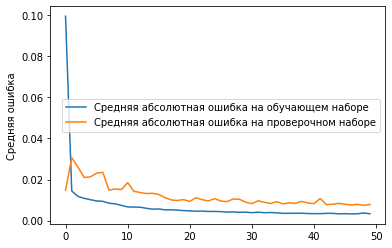

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

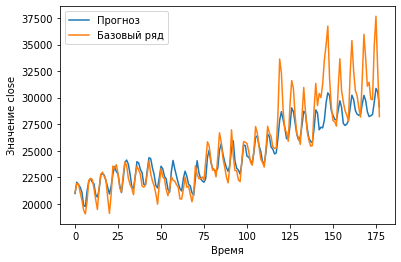

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

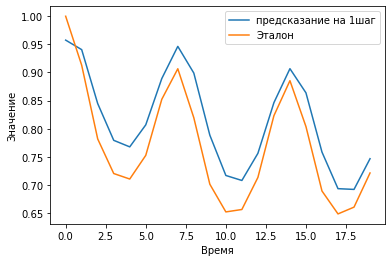

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 20, predVal, yValUnscaled)